This notebook is a duplicate of the one named `timing-vs-gaiaedr3-position-comparison`.

I removed two pulsar (PSR J1435-6100 and PSR J1955+2908) that were not considered as the genuine assocaitions to see how this action will affect the results.

Since the timing solutions for PSR J1435-6100 only appeared in one publication that was analyzed within the frame of DE200, I just need to check the implication on the comparison of DE200 versus *Gaia*.

In contrast, the timing solutions for PSR J1955+2908 were referred to DE200 (2 measurements), DE405 (1 measurements), DE421 (3 measurements), and DE436 (2 measurements).

In all, I consider DE200, DE405, DE421, DE430, and DE436 in this notebook.

- Remove two pulsars (PSR J1435-6100 and PSR J1955+2908) that are most likely not ture associations and one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the Gaia EDR3.

- Remove all data points with offset greater than 1 arcsec in the absolute sense in either RA or Dec. Such a discrepancy is unlikely linked to the frame mis-alignment. **(2022-05-05)** 

- Remove PSRs near the Ecliptic plane, i.e., the ecliptic latitude is within $\pm\,5\,^{\circ}$. **(2022-06-10)** 

- Fix a serious bug in computing the RA offset and its uncertainty **(2022-08-13)**

In [1]:
from functools import reduce

import numpy as np
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
from astropy.time import Time
from matplotlib import pyplot as plt
from psrcrf_tools import *
from statsmodels.iolib.table import SimpleTable

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

Prepare the data for further analyses.

## 1.1 Load the database

Read the timing solution data.

In [2]:
timing_table = Table.read(
    "../data/timing_edr3.fits",
)
timing_table.sort("psr_name")

Remove two pulsars (PSR J1435-6100 and PSR J1955+2908) that are most likely not ture associations and one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the *Gaia* EDR3.

In [3]:
mask = (
    (timing_table["psr_name"] != "J1435-6100")
    & (timing_table["psr_name"] != "J1955+2908")
    & (timing_table["psr_name"] != "J1546-5302")
)
timing_table = Table(timing_table[mask], masked=False)

Add unit information

In [4]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [5]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")

Only keep the astrometric parameters from Gaia.

In [6]:
edr3_antf_table = edr3_antf_table[
    "name",
    "source_id",
    "ra",
    "ra_error",
    "dec",
    "dec_error",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
]

edr3_antf_table.rename_columns(
    [
        "name",
        "ra_error",
        "dec_error",
        "parallax",
        "parallax_error",
        "pmra_error",
        "pmdec_error",
    ],
    ["psr_name", "ra_err", "dec_err", "plx", "plx_err", "pmra_err", "pmdec_err"],
)

Add unit information

In [7]:
edr3_antf_table["ra"].unit = u.deg
edr3_antf_table["dec"].unit = u.deg
edr3_antf_table["pmra"].unit = u.mas / u.yr
edr3_antf_table["pmdec"].unit = u.mas / u.yr
edr3_antf_table["plx"].unit = u.mas
edr3_antf_table["ra_err"].unit = u.mas
edr3_antf_table["dec_err"].unit = u.mas
edr3_antf_table["pmra_err"].unit = u.mas / u.yr
edr3_antf_table["pmdec_err"].unit = u.mas / u.yr
edr3_antf_table["plx_err"].unit = u.mas

Supplement the timing table with the Gaia astrometric information.

In [8]:
edr3_timing = join(
    timing_table,
    edr3_antf_table,
    keys="psr_name",
    join_type="left",
    table_names=["t", "g"],
)

count_psr_nb(edr3_timing)

There are 30 pulsars with 59 measurements.


## 1.2 Compute offsets between pulsar positions from timing and Gaia

Propagate the Gaia EDR3 position from J2016.0 to the timing positonal epoch and compute the positional offset,
in the sense of timing minus Gaia.

In [9]:
gaia_epoch = Time("2016.0", format="jyear").mjd
# 57388.5

In [10]:
# Epoch difference in Julian year
dt_y = (edr3_timing["pos_epoch"].value - gaia_epoch) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(edr3_timing["dec_g"].value))

dra = (
    edr3_timing["ra_t"] - edr3_timing["ra_g"]
) * dec_fac - dt_y * edr3_timing["pmra_g"]

ddec = edr3_timing["dec_t"] - edr3_timing["dec_g"] - \
    dt_y * edr3_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

edr3_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [11]:
edr3_timing["ra_err_t"] = edr3_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    edr3_timing["ra_err_g"] ** 2
    + edr3_timing["ra_err_t"] ** 2
    + (dt_y * edr3_timing["pmra_err_g"]).value ** 2
)

ddec_err = np.sqrt(
    edr3_timing["dec_err_g"] ** 2
    + edr3_timing["dec_err_t"] ** 2
    + (dt_y * edr3_timing["pmdec_err_g"]).value ** 2
)

edr3_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

## 1.3 Plot the sky distribution

Find pulsars according to the underlying reference frames the time positions are referring to.

In [12]:
mask = edr3_timing["eph"] == "DE200"
edr3_timing200 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE405"
edr3_timing405 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE421"
edr3_timing421 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE430"
edr3_timing430 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE436"
edr3_timing436 = edr3_timing[mask]

I plot the distribution for all pulsars in one figure.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


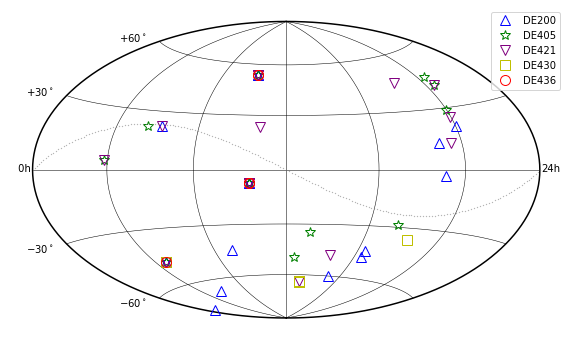

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, "$+%d^\circ$" % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, "$-%d^\circ$" % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(edr3_timing200["ra_g"], edr3_timing200["dec_g"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(edr3_timing405["ra_g"], edr3_timing405["dec_g"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(edr3_timing421["ra_g"], edr3_timing421["dec_g"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(edr3_timing430["ra_g"], edr3_timing430["dec_g"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(edr3_timing436["ra_g"], edr3_timing436["dec_g"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

# Ecliptic plane
lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

plt.savefig("../plots/edr3_psr.eps", dpi=100)

## 1.4 Compute statistics of position formal uncertainties

Compute the median positional formal uncertainties for each subset.

In [14]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((5, 6))

pos_err_tab[0, :] = calc_med_pos_err(edr3_timing200)
pos_err_tab[1, :] = calc_med_pos_err(edr3_timing405)
pos_err_tab[2, :] = calc_med_pos_err(edr3_timing421)
pos_err_tab[3, :] = calc_med_pos_err(edr3_timing430)
pos_err_tab[4, :] = calc_med_pos_err(edr3_timing436)

# 2 Compare timing and Gaia positions

##  2.1 DE200 vs Gaia EDR3

In [15]:
mask = edr3_timing["eph"] == "DE200"
edr3_timing200 = edr3_timing[mask]

nb_psr_200 = len(edr3_timing200.group_by("psr_name").groups)
nb_obs_200 = len(edr3_timing200)

print("We have", nb_psr_200,
      "pulsars in the sample from DE200 vs. Gaia DR3 comparison with",
      nb_obs_200, "observations.")
# edr3_timing200

We have 13 pulsars in the sample from DE200 vs. Gaia DR3 comparison with 15 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


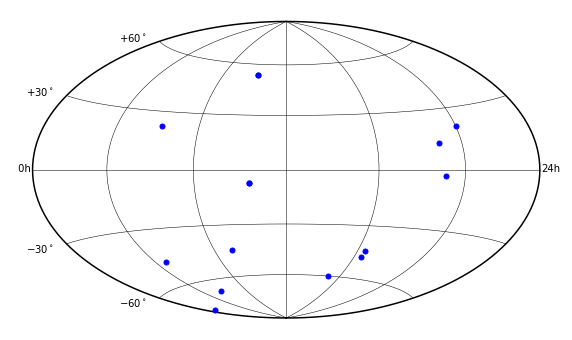

In [16]:
sou_dist_plot(
    edr3_timing200["ra_g"],
    edr3_timing200["dec_g"],
)
#               "../plots/de200_gedr3_psr.eps")

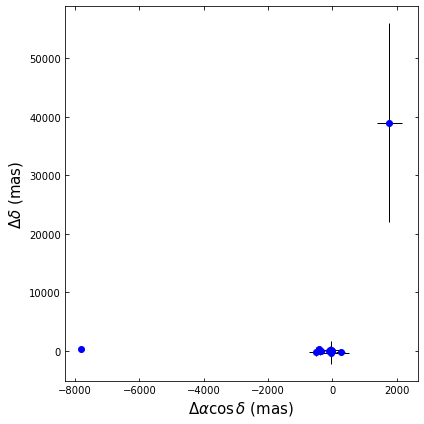

In [17]:
simple_plot(edr3_timing200)

First, we check the positional offset visually.

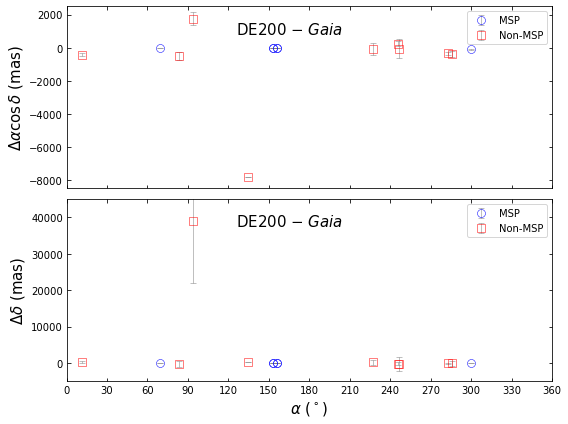

In [18]:
pos_oft_vs_coord(
    edr3_timing200,
    [-8500, 2500, -5000, 45000],
    # Prefit
    edr3_timing200["dra"],
    edr3_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$"],
    ref="g",
    xaxis="ra",
    divided=True)

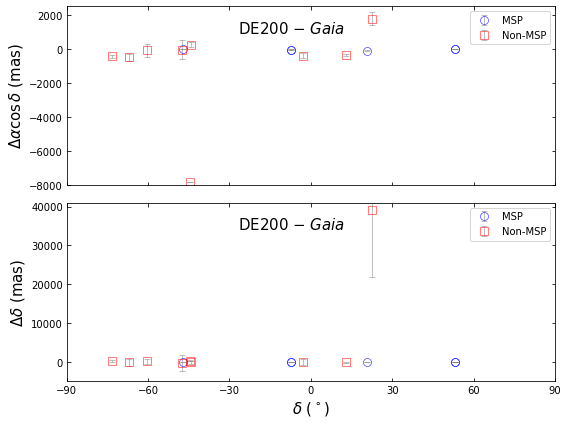

In [19]:
val_max = 1000
pos_oft_vs_coord(
    edr3_timing200,
    [-8000, 2500, -5000, 41000],
    # Prefit
    edr3_timing200["dra"],
    edr3_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$"],
    ref="g",
    xaxis="dec",
    divided=True)

Two data points are extremely far from the origin, which strongly suggests that there are outliers.

In [20]:
edr3_timing200[edr3_timing200["dra"] < -6000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0857-4424,J0857-4424,49080.0,DE200,134.47982916666663,-44.40286666666667,0.0,0.0,0.0,15.31262307634195,30.0,0.0,0.0,0.0,dsb+98,,5331775184393659264,134.4827918037,0.2053,-44.40291467708,0.2051,2.1185,0.2609,-8.27,0.296,7.742,0.271,-7807.9452450570325,348.9481163256417,16.728870188507926,30.627500667583664


When looking at all timing positions, I found that the timing position of `J0857-4424` was updated in **psj+19**, leading to a much smaller RA offset of -440 mas. 

Both timing solutions provide the position measurements only.

Comparing these timing positions, the RA offset is about 5 arcseconds.

Likely, the large RA offset between Gaia and timing positions seen here is due to the error in **dsb+98**.

In [21]:
dra_tmp = (96.07938072149757 - 96.07737732083464) * \
    np.cos(np.deg2rad(-44.40295833333333)) * 3600
print(
    "The RA offset between timing solutions given "
    "in the psj+19 and dsb+98 is {:.3f} arcsec.".format(dra_tmp))

The RA offset between timing solutions given in the psj+19 and dsb+98 is 5.153 arcsec.


In [22]:
edr3_timing[edr3_timing["psr_name"] == "J0857-4424"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0857-4424,J0857-4424,55335.0,DE4??,134.4826333333333,-44.40295833333333,0.0,0.0,0.0,15.312599083277878,20.0,0.0,0.0,0.0,psj+19,,5331775184393659264,134.4827918037,0.2053,-44.40291467708,0.2051,2.1185,0.2609,-8.27,0.296,7.742,0.271,-454.07698580959004,-113.635620826058,15.404131961789753,20.058999302161144
J0857-4424,J0857-4424,49080.0,DE200,134.47982916666663,-44.40286666666667,0.0,0.0,0.0,15.31262307634195,30.0,0.0,0.0,0.0,dsb+98,,5331775184393659264,134.4827918037,0.2053,-44.40291467708,0.2051,2.1185,0.2609,-8.27,0.296,7.742,0.271,-7807.9452450570325,348.9481163256417,16.728870188507926,30.627500667583664


In [23]:
edr3_timing200[edr3_timing200["ddec"] > 30000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0611+22,J0614+2229,49674.0,DE200,93.5715,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,hlk+04,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1765.1976921276275,38977.65460129038,384.3408169129133,17000.002796843564


In [24]:
edr3_timing[edr3_timing["psr_name"] == "J0614+2229"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0611+22,J0614+2229,49674.0,DE200,93.5715,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,hlk+04,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1765.1976921276275,38977.65460129038,384.3408169129133,17000.002796843564
B0611+22,J0614+2229,56000.0,DE421,93.57149999999999,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,lys+20,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1774.3944230865225,38992.75733092761,384.082595602791,17000.000098755143


In [25]:
edr3_timing200[edr3_timing200["dra"] > 1500]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0611+22,J0614+2229,49674.0,DE200,93.5715,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,hlk+04,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1765.1976921276275,38977.65460129038,384.3408169129133,17000.002796843564


It should noted that for `J0614+2229`, there are two timing solutions, in which the positional uncertainties are $0.4^{''}$ and $17^{''}$, respectively.

The Gaia positional uncertainty is about 0.5 mas.

The positional differences between timing position in **hlk+04** and Gaia are  $\Delta \alpha^* \simeq 1.8^{''}$，$\Delta\delta \simeq ~39.0^{''}$, likely caused by errors in the timing position.

**lys+20**(DE421) gives similar results to those in **hlk+04**.

Change the limits of the X- and Y-axes to remove the extremely large offsets. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


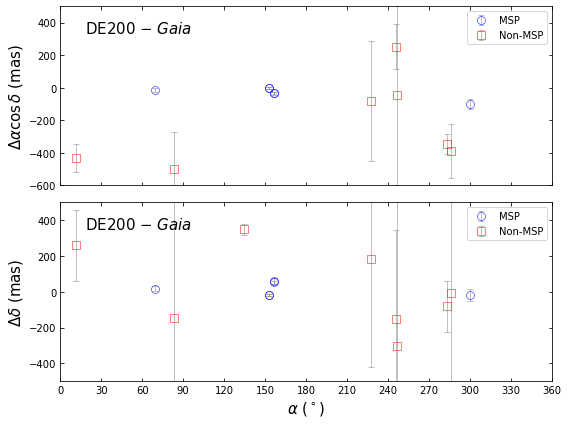

In [26]:
pos_oft_vs_coord(
    edr3_timing200,
    [-600, 500, -500, 500],
    # Prefit
    edr3_timing200["dra"],
    edr3_timing200["ddec"],
    fig_name="gedr3_pos-oft-vs-ra-de200.eps",
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$"],
    ref="g",
    xaxis="ra",
    divided=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


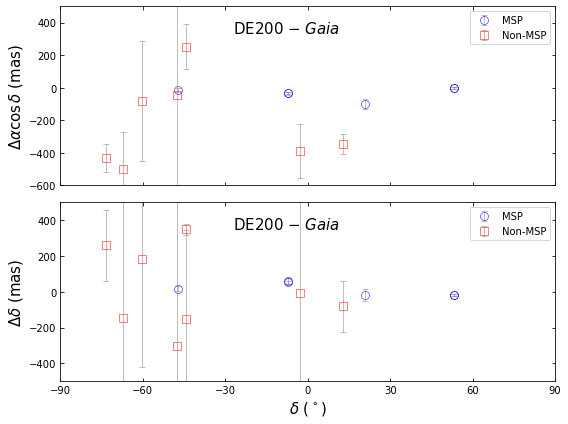

In [27]:
val_max = 1000
pos_oft_vs_coord(
    edr3_timing200,
    [-600, 500, -500, 500],
    # Prefit
    edr3_timing200["dra"],
    edr3_timing200["ddec"],
    fig_name="gedr3_pos-oft-vs-dec-de200.eps",
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$"],
    ref="g",
    xaxis="dec",
    divided=True)

## 2.2 DE405 vs Gaia EDR3

In [28]:
mask = edr3_timing["eph"] == "DE405"
edr3_timing405 = edr3_timing[mask]

nb_psr_405 = len(edr3_timing405.group_by("psr_name").groups)
nb_obs_405 = len(edr3_timing405)

print("We have", nb_psr_405,
      "pulsars in the sample from DE405 vs. Gaia DR3 comparison with",
      nb_obs_405, "observations.")

# edr3_timing405

We have 11 pulsars in the sample from DE405 vs. Gaia DR3 comparison with 12 observations.


Plot the sky distribution.

/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


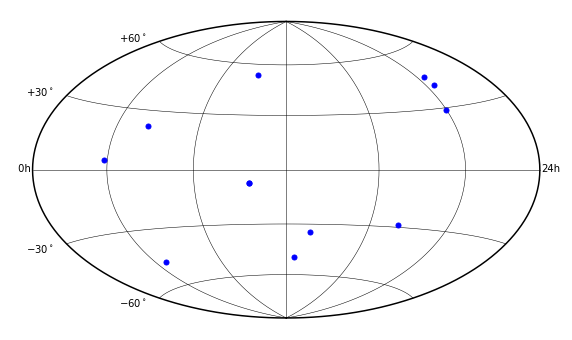

In [29]:
sou_dist_plot(edr3_timing405["ra_g"], edr3_timing405["dec_g"])

In [30]:
print("We have", nb_psr_405,
      "pulsars in the sample from DE405 vs. Gaia DR3 comparison with",
      nb_obs_405, "observations.")
# edr3_timing405

We have 11 pulsars in the sample from DE405 vs. Gaia DR3 comparison with 12 observations.


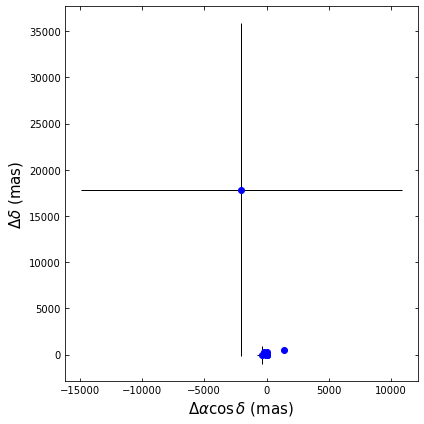

In [31]:
simple_plot(edr3_timing405)

Plot the relationship between position offsets and RA/DEC.

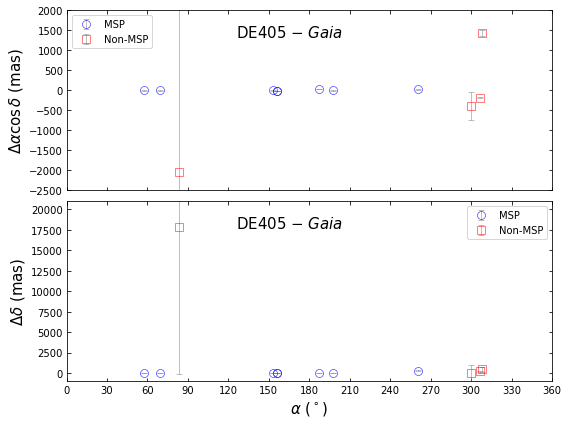

In [32]:
pos_oft_vs_coord(edr3_timing405, [-2500, 2000, -1000, 21000],
                 edr3_timing405["dra"],
                 edr3_timing405["ddec"],
                 ref="g",
                 xaxis="ra",
                 add_text=[0.35, 0.85, "DE405 $-$ $Gaia$"],
                 divided=True)

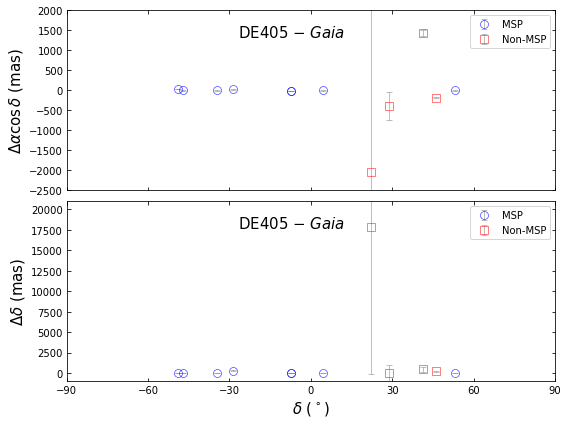

In [33]:
pos_oft_vs_coord(edr3_timing405, [-2500, 2000, -1000, 21000],
                 edr3_timing405["dra"],
                 edr3_timing405["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.35, 0.85, "DE405 $-$ $Gaia$"],
                 divided=True)

Again, there are two PSRs which requires checked in detail.

In [34]:
edr3_timing405[edr3_timing405["ddec"] > 1000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0531+21,J0534+2200,51816.0,DE405,83.6325,22.019444444444442,0.0,0.0,0.0,12891.96117982677,18000.0,0.0,0.0,0.0,zhw+05,,3403818172572314624,83.63305926164,0.0732,22.01449736799,0.0606,0.511,0.0788,-11.513,0.098,2.302,0.064,-2042.1972938766467,17844.59609841552,12891.961266735338,18000.000026585618


In [35]:
edr3_timing[edr3_timing["psr_name"] == "J0534+2200"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0531+21,J0534+2200,51816.0,DE405,83.6325,22.019444444444442,0.0,0.0,0.0,12891.96117982677,18000.0,0.0,0.0,0.0,zhw+05,,3403818172572314624,83.63305926164,0.0732,22.01449736799,0.0606,0.511,0.0788,-11.513,0.098,2.302,0.064,-2042.1972938766467,17844.59609841552,12891.961266735338,18000.000026585618


The formal uncertainty for the timing position of J0534+2200 in zhw+05 is 14 arcsec in RA and 18 arcsec in Dec, therefore it is not surprising that a large deviation of -2 arcsec in RA and 18 arcsec in Dec was found with respect to the Gaia position.

The position given in the ATNF comes from optical observations.

In [36]:
edr3_timing405[edr3_timing405["dra"] > 1000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J2032+4127,J2032+4127,54938.0,DE405,308.0552083333333,41.45688888888889,0.0,0.0,0.0,84.25238276271156,300.0,0.0,0.0,0.0,rkp+11,,2067835682818358400,308.05466935591,0.0119,41.45675875004,0.0146,0.5678,0.0156,-2.876,0.017,-0.948,0.02,1434.8873294314344,462.13962601859515,84.25246080259053,300.0000303633104


The positional offset in RA and Dec is 1.4 arcsec and 0.5 arcsec, respectively.

In [37]:
edr3_timing[edr3_timing["psr_name"] == "J2032+4127"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J2032+4127,J2032+4127,55700.0,DE421,308.0546625,41.45676111111111,0.0,0.0,0.0,16.8505097491912,20.0,0.0,0.0,0.0,hnl+17,,2067835682818358400,308.05466935591,0.0119,41.45675875004,0.0146,0.5678,0.0156,-2.876,0.017,-0.948,0.02,-31.792868580436437,4.11738372058315,16.85069721381278,20.00021903624383
J2032+4127,J2032+4127,54938.0,DE405,308.0552083333333,41.45688888888889,0.0,0.0,0.0,84.25238276271156,300.0,0.0,0.0,0.0,rkp+11,,2067835682818358400,308.05466935591,0.0119,41.45675875004,0.0146,0.5678,0.0156,-2.876,0.017,-0.948,0.02,1434.8873294314344,462.13962601859515,84.25246080259053,300.0000303633104


The updated position for this PSR in hnl+17 shows much less deviations from the Gaia one, i.e., -29 mas in RA and 4 mas in Dec.

So likely, the timing position given in the rkp+11 is wrong.

It should be noted that **some MSPs** show large position offsets. 

In [38]:
edr3_timing405[edr3_timing405["ddec"] > 50]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0531+21,J0534+2200,51816.0,DE405,83.6325,22.019444444444442,0.0,0.0,0.0,12891.96117982677,18000.0,0.0,0.0,0.0,zhw+05,,3403818172572314624,83.63305926164,0.0732,22.01449736799,0.0606,0.511,0.0788,-11.513,0.098,2.302,0.064,-2042.1972938766467,17844.59609841552,12891.961266735338,18000.000026585618
J1024-0719,J1024-0719,53000.0,DE405,156.16120191666664,-7.3219916666666665,-35.3,-48.2,0.0,0.44269078222525615,1.0,0.2,0.30000000000000004,0.0,vbc+09,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.333138917466318,68.19988291351254,3.854752814156184,4.411851559882681
J1024-0719,J1024-0719,53000.0,DE405,156.161201875,-7.321991722222222,-34.9,-47.0,0.0,0.2951271881134008,0.6000000000000001,0.4,1.0,0.0,hbo06,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.481915645989176,67.99988291295168,3.840604664208689,4.338713425249384
J1723-2837,J1723-2837,55667.0,DE405,260.8466066666666,-28.63254722222222,0.0,0.0,0.0,9.244506892240288,110.0,0.0,0.0,0.0,cls+13,,4059795674516044800,260.8465812119,0.0355,-28.63266533424,0.0253,1.0663,0.0439,-11.734,0.044,-24.05,0.034,25.126036733080298,311.8505603691683,9.24690082739917,110.00011963574535
J2027+4557,J2027+4557,54250.0,DE405,306.81763749999993,45.96585555555556,0.0,0.0,0.0,21.74158997373989,40.0,0.0,0.0,0.0,jsb+09,,2071054503122390144,306.81771537777,0.0234,45.96578561394,0.0247,0.518,0.0267,2.083,0.034,-2.12,0.032,-176.97610998844357,233.57319725076567,21.743565386302357,40.00095270612531
J2032+4127,J2032+4127,54938.0,DE405,308.0552083333333,41.45688888888889,0.0,0.0,0.0,84.25238276271156,300.0,0.0,0.0,0.0,rkp+11,,2067835682818358400,308.05466935591,0.0119,41.45675875004,0.0146,0.5678,0.0156,-2.876,0.017,-0.948,0.02,1434.8873294314344,462.13962601859515,84.25246080259053,300.0000303633104


One example is J1723-2837, whose Dec offset is about -466 mas.

In [39]:
edr3_timing[edr3_timing["psr_name"] == "J1723-2837"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1723-2837,J1723-2837,55667.0,DE405,260.8466066666666,-28.63254722222222,0.0,0.0,0.0,9.244506892240288,110.0,0.0,0.0,0.0,cls+13,,4059795674516044800,260.8465812119,0.0355,-28.63266533424,0.0253,1.0663,0.0439,-11.734,0.044,-24.05,0.034,25.126036733080298,311.8505603691683,9.24690082739917,110.00011963574535


The other example is `PSR J1024-0719`, whose Dec offset is about 69 mas.

In [40]:
edr3_timing[edr3_timing["psr_name"] == "J1024-0719"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1024-0719,J1024-0719,55000.0,DE421,156.1611474146,-7.3220649833,-35.319,-48.285,0.831,0.0608530850650274,0.12732461,0.027289,0.055563,0.135896,vlh+16,IPTA-DR1,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.78311947222694,69.02112543238276,2.095902373324462,2.3520260174863914
J1024-0719,J1024-0719,55000.0,DE436,156.1611475046,-7.3220649306,-35.267,-48.225,0.822,0.04761904337019902,0.09847672,0.017593,0.036161,0.102243,pdd+19,IPTA-DR2,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.46176167772735,69.21084543209305,2.0955598855286084,2.3506408689978997
J1024-0719,J1024-0719,55000.0,DE421,156.16114740833333,-7.322064986111111,-35.28,-48.18,0.8,0.07378178490567323,0.15,0.03,0.07,0.17,dcl+16,EPTA,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.805495527107208,69.01100543154543,2.0963175838429273,2.3533624520292755
J1024-0719,J1024-0719,55636.0,DE436,156.1611309125,-7.322087388888889,-35.27,-48.22,0.83,0.059025424959002266,0.1,0.017,0.03,0.13,rsc+21,PPTA-DR2e,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-15.964160993669262,72.55504239258222,1.5479793851124006,1.7348689477526171
J1024-0719,J1024-0719,53000.0,DE405,156.16120191666664,-7.3219916666666665,-35.3,-48.2,0.0,0.44269078222525615,1.0,0.2,0.30000000000000004,0.0,vbc+09,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.333138917466318,68.19988291351254,3.854752814156184,4.411851559882681
J1024-0719,J1024-0719,50456.0,DE200,156.16126666666665,-7.3219025,-41.0,-70.0,0.0,1.475636235828492,3.0,2.0,3.0,0.0,tsb+99,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-34.10226973775073,52.42373506807588,6.218661423952087,7.414762096101999
J1024-0719,J1024-0719,51018.0,DE200,156.16125125,-7.321920833333333,-35.0,-48.0,0.0,5.902544700634462,15.0,4.0,8.0,0.0,hlk+04,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-34.591441343089976,60.821610496232104,8.103529905512335,16.243039568406545
J1024-0719,J1024-0719,53000.0,DE405,156.161201875,-7.321991722222222,-34.9,-47.0,0.0,0.2951271881134008,0.6000000000000001,0.4,1.0,0.0,hbo06,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.481915645989176,67.99988291295168,3.840604664208689,4.338713425249384


In [41]:
edr3_timing[edr3_timing["psr_name"] == "J1024-0719"]["ddec"]/edr3_timing[edr3_timing["psr_name"] == "J1024-0719"]["ddec_err"]

29.34539198088701
29.443394073888577
29.324427001050385
41.82162721084577
15.458335800247571
7.070184368509337
3.7444722239384873
15.672821928552038
43.237579502966646
59.48959682661634
24.28222589495689


Change the limits of the X- and Y- axes.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


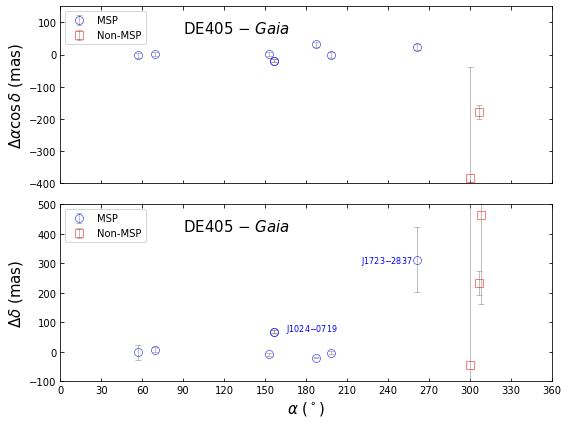

In [103]:
pos_oft_vs_coord(edr3_timing405, [-400, 150, -100, 500],
                 edr3_timing405["dra"],
                 edr3_timing405["ddec"],
                 fig_name="gedr3_pos-oft-vs-ra-de405.eps",
                 add_text=[0.25, 0.85, "DE405 $-$ $Gaia$"],
                 add_text_msp=[[220, 300, "J1723$-$2837", 1],
                               [165, 70, "J1024$-$0719", 1]],
                 ref="g",
                 xaxis="ra",
                 divided=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


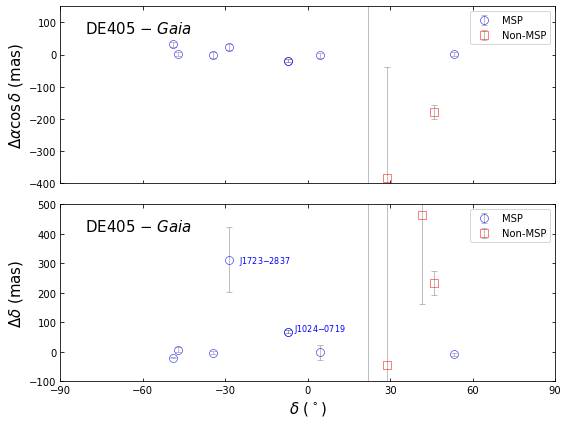

In [43]:
pos_oft_vs_coord(edr3_timing405, [-400, 150, -100, 500],
                 edr3_timing405["dra"],
                 edr3_timing405["ddec"],
                 fig_name="gedr3_pos-oft-vs-dec-de405.eps",
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE405 $-$ $Gaia$"],
                 add_text_msp=[[-25, 300, "J1723$-$2837", 1],
                               [-5, 70, "J1024$-$0719", 1]],
                 divided=True)

## 2.3 DE421 vs Gaia EDR3

In [44]:
mask = edr3_timing["eph"] == "DE421"
edr3_timing421 = edr3_timing[mask]

nb_psr_421 = len(edr3_timing421.group_by("psr_name").groups)
nb_obs_421 = len(edr3_timing421)

print("We have", nb_psr_421,
      "pulsars in the sample from DE421 vs. Gaia DR3 comparison with",
      nb_obs_421, "observations.")

We have 12 pulsars in the sample from DE421 vs. Gaia DR3 comparison with 19 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


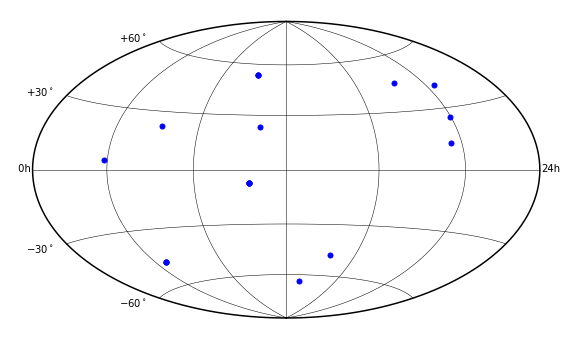

In [45]:
sou_dist_plot(edr3_timing421["ra_g"], edr3_timing421["dec_g"])
#               "../plots/gedr3_de421_psr.eps")

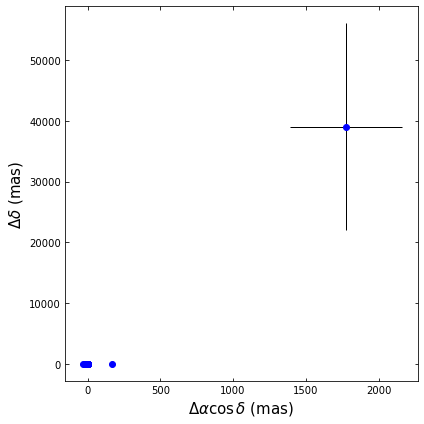

In [46]:
simple_plot(edr3_timing421)

Obviously, there is one measurment is far from the other points.

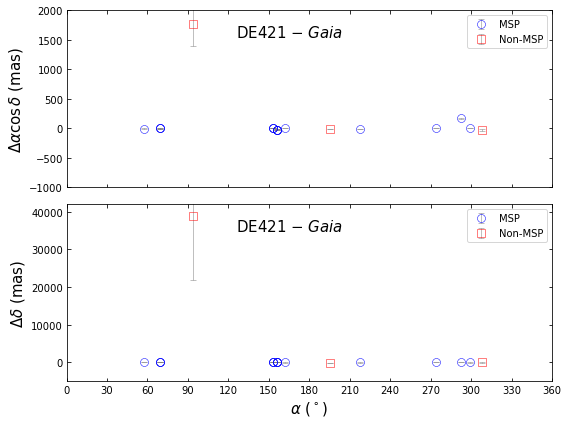

In [47]:
pos_oft_vs_coord(edr3_timing421, [-1000, 2000, -5000, 42000],
                 edr3_timing421["dra"],
                 edr3_timing421["ddec"],
                 add_text=[0.35, 0.85, "DE421 $-$ $Gaia$"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

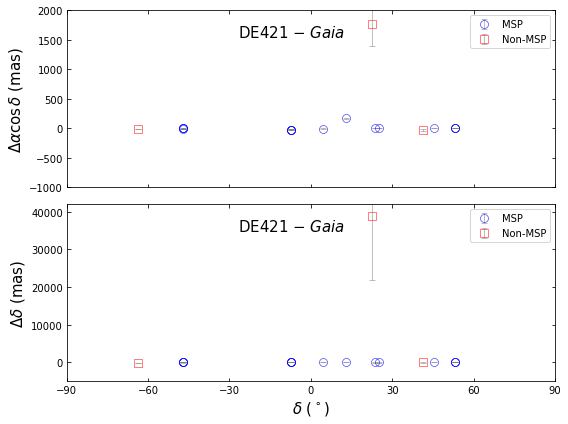

In [48]:
pos_oft_vs_coord(edr3_timing421, [-1000, 2000, -5000, 42000],
                 edr3_timing421["dra"],
                 edr3_timing421["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.35, 0.85, "DE421 $-$ $Gaia$"],
                 divided=True)

Find the coresponding PSR for the large offset and it is PSR `J0614+2229`.

In [49]:
edr3_timing421[edr3_timing421["dra"] > 1000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0611+22,J0614+2229,56000.0,DE421,93.57149999999999,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,lys+20,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1774.3944230865225,38992.75733092761,384.082595602791,17000.000098755143


When checking all the timing position for `PSR J0614+2229`, the one publised in 2004 also shows a large offset. 
It is thus likely that this match is problematic.

In [50]:
edr3_timing[edr3_timing["psr_name"] == "J0614+2229"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0611+22,J0614+2229,49674.0,DE200,93.5715,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,hlk+04,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1765.1976921276275,38977.65460129038,384.3408169129133,17000.002796843564
B0611+22,J0614+2229,56000.0,DE421,93.57149999999999,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,lys+20,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1774.3944230865225,38992.75733092761,384.082595602791,17000.000098755143


In [51]:
edr3_timing421[edr3_timing421["dra"] > 150]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0611+22,J0614+2229,56000.0,DE421,93.57149999999999,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,lys+20,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1774.3944230865225,38992.75733092761,384.082595602791,17000.000098755143
J1928+1245,J1928+1245,57974.0,DE421,292.18913999999995,12.76482611111111,0.0,0.0,0.0,0.8560631165089193,3.0,0.0,0.0,0.0,pkr+19,PALFA,4316237348443952128,292.18909202584,0.113,12.7648102135,0.1328,0.1483,0.1697,-0.35,0.157,-4.621,0.156,168.99961848995662,64.63891676607382,0.8994177401030284,3.0133321676296654


In [52]:
edr3_timing421[edr3_timing421["ddec"] > 50]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0611+22,J0614+2229,56000.0,DE421,93.57149999999999,22.51,0.0,0.0,0.0,384.0735626628858,17000.0,0.0,0.0,0.0,lys+20,,3376990741688176384,93.57096589888,0.5437,22.49916775771,0.5352,-1.224,0.6783,-0.531,0.678,-0.872,0.461,1774.3944230865225,38992.75733092761,384.082595602791,17000.000098755143
J1024-0719,J1024-0719,55000.0,DE421,156.1611474146,-7.3220649833,-35.319,-48.285,0.831,0.0608530850650274,0.12732461,0.027289,0.055563,0.135896,vlh+16,IPTA-DR1,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.78311947222694,69.02112543238276,2.095902373324462,2.3520260174863914
J1024-0719,J1024-0719,55000.0,DE421,156.16114740833333,-7.322064986111111,-35.28,-48.18,0.8,0.07378178490567323,0.15,0.03,0.07,0.17,dcl+16,EPTA,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.805495527107208,69.01100543154543,2.0963175838429273,2.3533624520292755
J1024-0719,J1024-0719,55800.0,DE421,156.1611257875,-7.322094333333333,-35.2,-48.0,0.6,0.13280720408941352,0.30000000000000004,0.1,0.2,0.30000000000000004,mnf+16,NANOGrav-9yr,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.342795927511094,69.26545443936156,1.4124670447519716,1.6019734507711996
J1024-0719,J1024-0719,54500.0,DE421,156.1611609737,-7.3220466056,-35.331,-48.318,0.526,0.09070604847899366,0.18954466,0.039686,0.079472,0.228211,rhc+16,PPTA-DR1e,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.9077745494195,68.99056480273559,2.529295428174582,2.8411960707878947
J1928+1245,J1928+1245,57974.0,DE421,292.18913999999995,12.76482611111111,0.0,0.0,0.0,0.8560631165089193,3.0,0.0,0.0,0.0,pkr+19,PALFA,4316237348443952128,292.18909202584,0.113,12.7648102135,0.1328,0.1483,0.1697,-0.35,0.157,-4.621,0.156,168.99961848995662,64.63891676607382,0.8994177401030284,3.0133321676296654


In [53]:
edr3_timing[edr3_timing["psr_name"] == "J1928+1245"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1928+1245,J1928+1245,57974.0,DE421,292.18913999999995,12.76482611111111,0.0,0.0,0.0,0.8560631165089193,3.0,0.0,0.0,0.0,pkr+19,PALFA,4316237348443952128,292.18909202584,0.113,12.7648102135,0.1328,0.1483,0.1697,-0.35,0.157,-4.621,0.156,168.99961848995662,64.63891676607382,0.8994177401030284,3.0133321676296654


Shorten the limits of the X- and Y- axes.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


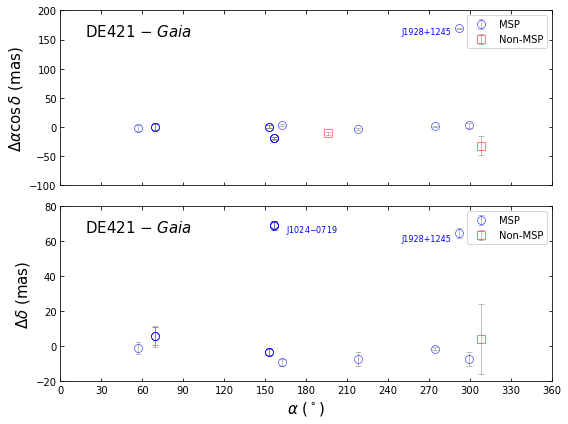

In [54]:
pos_oft_vs_coord(edr3_timing421, [-100, 200, -20, 80],
                 edr3_timing421["dra"],
                 edr3_timing421["ddec"],
                 fig_name="gedr3_pos-oft-vs-ra-de421.eps",
                 add_text=[0.05, 0.85, "DE421 $-$ $Gaia$"],
                 add_text_msp=[[250, 160, "J1928+1245", 0],
                               [165, 65, "J1024$-$0719", 1],
                               [250, 60, "J1928+1245", 1]],
                 ref="g",
                 xaxis="ra",
                 divided=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


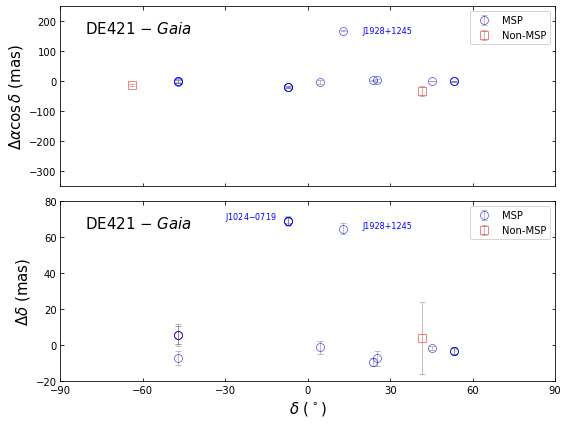

In [55]:
pos_oft_vs_coord(edr3_timing421, [-350, 250, -20, 80],
                 edr3_timing421["dra"],
                 edr3_timing421["ddec"],
                 fig_name="gedr3_pos-oft-vs-dec-de421.eps",
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE421 $-$ $Gaia$"],
                 add_text_msp=[[20, 160, "J1928+1245", 0],
                               [-30,70, "J1024$-$0719", 1],
                               [20, 65, "J1928+1245", 1]],
                 divided=True)

## 2.4 DE430 vs Gaia EDR3

In [56]:
mask = edr3_timing["eph"] == "DE430"
edr3_timing430 = edr3_timing[mask]

nb_psr_430 = len(edr3_timing430.group_by("psr_name").groups)
nb_obs_430 = len(edr3_timing430)

count_psr_nb(edr3_timing430)

There are 4 pulsars with 5 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


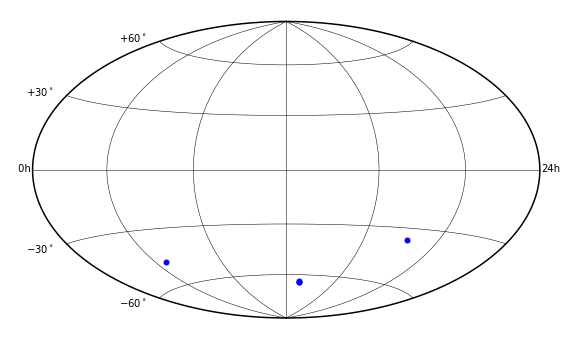

In [57]:
sou_dist_plot(
    edr3_timing430["ra_g"],
    edr3_timing430["dec_g"],
)
#               "../plots/gedr3_de436_psr.eps")

In [58]:
print("We have", nb_psr_430,
      "pulsars in the sample from DE430 vs. Gaia DR3 comparison with",
      nb_obs_430, "observations.")
# edr3_timing430

We have 4 pulsars in the sample from DE430 vs. Gaia DR3 comparison with 5 observations.


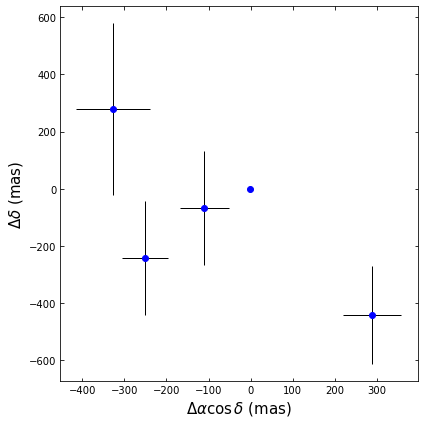

In [59]:
simple_plot(edr3_timing430)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


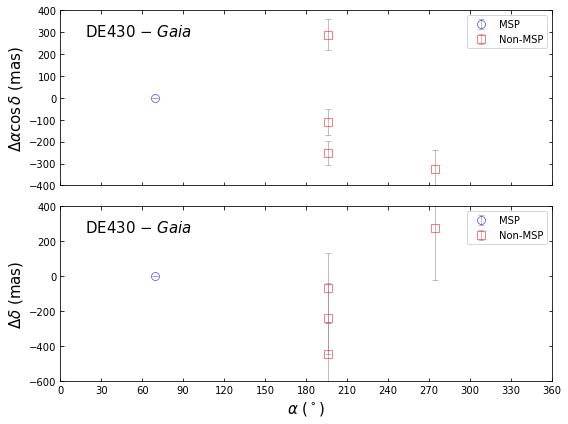

In [60]:
pos_oft_vs_coord(edr3_timing430, [-400, 400, -600, 400],
                 edr3_timing430["dra"],
                 edr3_timing430["ddec"],
                 fig_name="gedr3_pos-oft-vs-ra-de430.eps",
                 add_text=[0.05, 0.85, "DE430 $-$ $Gaia$"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


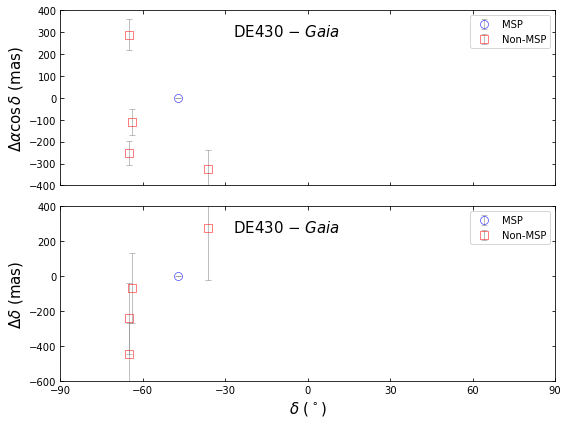

In [61]:
pos_oft_vs_coord(edr3_timing430, [-400, 400, -600, 400],
                 edr3_timing430["dra"],
                 edr3_timing430["ddec"],
                 fig_name="gedr3_pos-oft-vs-dec-de430.eps",
                 add_text=[0.35, 0.85, "DE430 $-$ $Gaia$"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

## 2.5 DE436 vs Gaia EDR3

In [62]:
mask = edr3_timing["eph"] == "DE436"
edr3_timing436 = edr3_timing[mask]

nb_psr_436 = len(edr3_timing436.group_by("psr_name").groups)
nb_obs_436 = len(edr3_timing436)

count_psr_nb(edr3_timing436)

There are 3 pulsars with 6 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


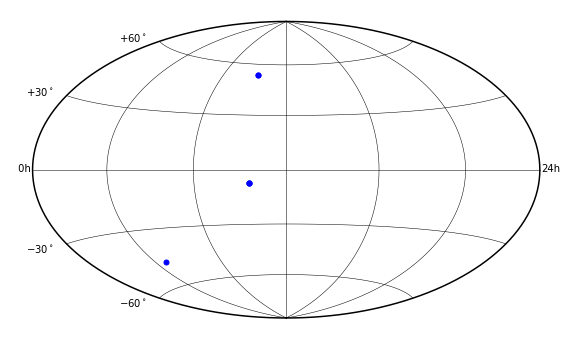

In [63]:
sou_dist_plot(
    edr3_timing436["ra_g"],
    edr3_timing436["dec_g"],
)
#               "../plots/gedr3_de436_psr.eps")

In [64]:
print("We have", nb_psr_436,
      "pulsars in the sample from DE436 vs. Gaia DR3 comparison with",
      nb_obs_436, "observations.")
# edr3_timing436

We have 3 pulsars in the sample from DE436 vs. Gaia DR3 comparison with 6 observations.


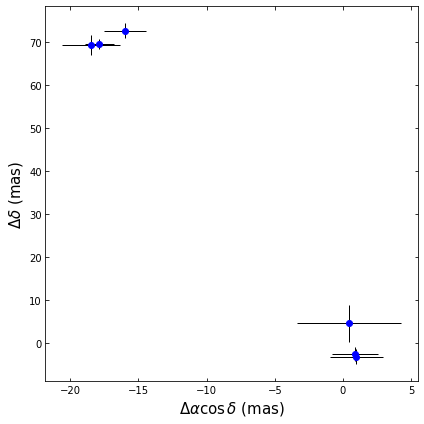

In [65]:
simple_plot(edr3_timing436)

In [66]:
edr3_timing436[edr3_timing436["dra"] < -10]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1024-0719,J1024-0719,55000.0,DE436,156.1611475046,-7.3220649306,-35.267,-48.225,0.822,0.04761904337019902,0.09847672,0.017593,0.036161,0.102243,pdd+19,IPTA-DR2,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.46176167772735,69.21084543209305,2.0955598855286084,2.3506408689978997
J1024-0719,J1024-0719,55636.0,DE436,156.1611309125,-7.322087388888889,-35.27,-48.22,0.83,0.059025424959002266,0.1,0.017,0.03,0.13,rsc+21,PPTA-DR2e,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-15.964160993669262,72.55504239258222,1.5479793851124006,1.7348689477526171
J1024-0719,J1024-0719,56239.0,DE436,156.16111399166664,-7.3221103888888885,-35.29,-48.2,0.8,0.08853813287160019,0.2,0.06,0.1,0.2,abb+18,NANOGrav-11yr,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-17.84394723600126,69.58052083322342,1.0364132500526133,1.169625019245252


In [67]:
edr3_timing436[edr3_timing436["ddec"] > 50]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1024-0719,J1024-0719,55000.0,DE436,156.1611475046,-7.3220649306,-35.267,-48.225,0.822,0.04761904337019902,0.09847672,0.017593,0.036161,0.102243,pdd+19,IPTA-DR2,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.46176167772735,69.21084543209305,2.0955598855286084,2.3506408689978997
J1024-0719,J1024-0719,55636.0,DE436,156.1611309125,-7.322087388888889,-35.27,-48.22,0.83,0.059025424959002266,0.1,0.017,0.03,0.13,rsc+21,PPTA-DR2e,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-15.964160993669262,72.55504239258222,1.5479793851124006,1.7348689477526171
J1024-0719,J1024-0719,56239.0,DE436,156.16111399166664,-7.3221103888888885,-35.29,-48.2,0.8,0.08853813287160019,0.2,0.06,0.1,0.2,abb+18,NANOGrav-11yr,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-17.84394723600126,69.58052083322342,1.0364132500526133,1.169625019245252


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


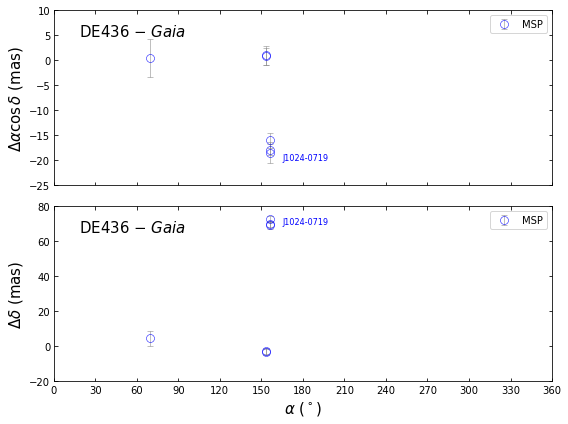

In [68]:
pos_oft_vs_coord(edr3_timing436, [-25, 10, -20, 80],
                 edr3_timing436["dra"],
                 edr3_timing436["ddec"],
                 fig_name="gedr3_pos-oft-vs-ra-de436.eps",
                 add_text=[0.05, 0.85, "DE436 $-$ $Gaia$"],
                 add_text_msp=[
    [165, -20, "J1024-0719", 0],
    [165, 70, "J1024-0719", 1]],
    ref="g",
    xaxis="ra",
    divided=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


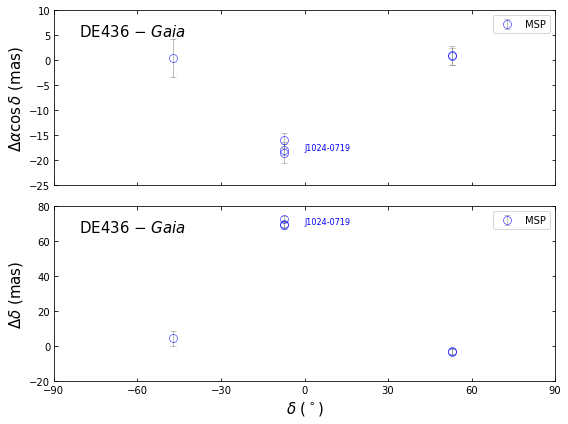

In [69]:
pos_oft_vs_coord(edr3_timing436, [-25, 10, -20, 80],
                 edr3_timing436["dra"],
                 edr3_timing436["ddec"],
                 fig_name="gedr3_pos-oft-vs-dec-de436.eps",
                 add_text=[0.05, 0.85, "DE436 $-$ $Gaia$"],
                 add_text_msp=[
    [0, -18, "J1024-0719", 0],
    [0, 70, "J1024-0719", 1]],
                 ref="g",
                 xaxis="dec",
                 divided=True)

# 3 Compare timing and Gaia reference frames

## 3.1 Remove pulsars near the ecliptic plane

Remove PSRs near the Ecliptic plane within 10 degrees.

In [70]:
mask = (
    (edr3_timing["psr_name"] != "J0614+2229")
    & (edr3_timing["psr_name"] != "J0534+2200")
    & (edr3_timing["psr_name"] != "J0337+1715")
    & (edr3_timing["psr_name"] != "J2339-0533")
    #     & (edr3_timing["psr_name"] != "J1723-2837")
    #     & (edr3_timing["psr_name"] != "J2129-0429")
    #     & (edr3_timing["psr_name"] != "J1023+0038")
)
edr3_timing = Table(edr3_timing[mask], masked=False)

In [71]:
mask = edr3_timing["eph"] == "DE200"
edr3_timing200 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE405"
edr3_timing405 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE421"
edr3_timing421 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE430"
edr3_timing430 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE436"
edr3_timing436 = edr3_timing[mask]

In [72]:
nb_psr_200 = len(edr3_timing200.group_by("psr_name").groups)
nb_obs_200 = len(edr3_timing200)

nb_psr_405 = len(edr3_timing405.group_by("psr_name").groups)
nb_obs_405 = len(edr3_timing405)

nb_psr_421 = len(edr3_timing421.group_by("psr_name").groups)
nb_obs_421 = len(edr3_timing421)

nb_psr_430 = len(edr3_timing430.group_by("psr_name").groups)
nb_obs_430 = len(edr3_timing430)

nb_psr_436 = len(edr3_timing436.group_by("psr_name").groups)
nb_obs_436 = len(edr3_timing436)

## 3.2 DE200 vs. Gaia

Do the LSQ fitting iterately.

In [73]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    edr3_timing200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 12   9091.6   8133.0     527.42    -309.11    -522.18 J0857-4424    49080 176230.7
 2 11     10.3      7.6      17.34     -12.45     -32.76 J1024-0719    50456     58.7
 3 11      7.4      4.7      13.52     -24.02     -33.72 J1024-0719    51018     22.7
 4 10      6.4      3.9      14.25     -28.27     -37.01 J1851+1259    49908     24.2
 5  9      5.2      2.9       7.29     -25.07     -25.74 J0045-7319    49144     25.4
 6  8      4.1      1.5       9.03     -25.37     -27.15 J1012+5307    50700      0.1
 7  8      3.4      1.7      10.34     -24.35     -27.40 J1012+5307    50914      0.2
 8  7      2.7      1.7      28.30      23.63     -67.60 J1959+2048    48196      1.8
 9  6      2.1      1.6      -0.23     -52.83      29.63 J1903-0258    53095      6.5
10  5      1.9      0.7     -44.43    -170.38     168.08 J0534-6703    52410      3.2
11  4      1.6      0.3     -34.62    -143.46     138.

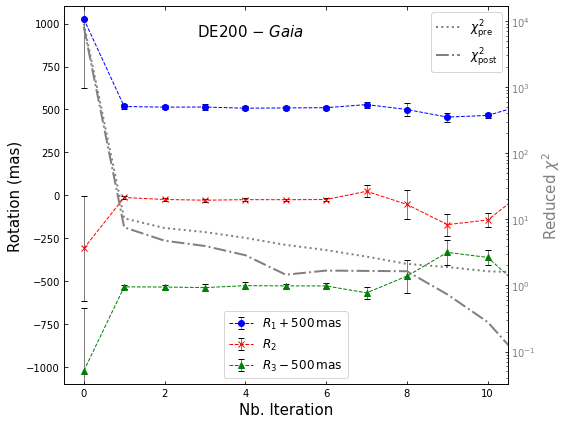

In [74]:
rot_vs_iter(pmt200,
            sig200, [-0.5, 10.5, -1100, 1100],
            #             "gedr3_orient-de200.eps",
            elw=0.5,
            add_text=[0.3, 0.92, "DE200 $-$ $Gaia$"],
            apr_chi2=apr_chi2_200,
            pst_chi2=pst_chi2_200,
            ax_loc="lower center",
            ax1_loc="upper right",
            y_shift=500)

I used the median values of the parameter estimations as the final estimate of rotation parameters.

The uncertainties of these estimates are given by interquatile range scaled by a factor of 1/1.35.

This was done also for the comparison of DE405, DE421, DE430, and DE436.

In [75]:
rot200, iqr200 = find_pmt_est(pmt200)

Calculate the postfit residuals.

In [76]:
dra_200, ddec_200 = calc_dpos(edr3_timing200, rot200)

Calculate the reduced $\chi^2$ before and after the LSQ adjustements.

In [77]:
a_chi2_200, p_chi2_200 = calc_chi2_4_fit(edr3_timing200, dra_200, ddec_200)

When removing these two PSRs, 

In [78]:
# mask = (edr3_timing200["psr_name"] != "J0857-4424")

mask = ((np.fabs(edr3_timing200["dra"]) < 1000)
        & (np.fabs(edr3_timing200["ddec"]) < 1000)
        )

edr3_timing200_a = edr3_timing200[mask]

In [79]:
nb_psr_200 = len(edr3_timing200_a.group_by("psr_name").groups)
nb_obs_200 = len(edr3_timing200_a)

print("After removing outliers, we have", nb_psr_200,
      "pulsars in the sample from DE200 vs. Gaia DR3 comparison with",
      nb_obs_200, "observations.")

After removing outliers, we have 11 pulsars in the sample from DE200 vs. Gaia DR3 comparison with 13 observations.


and I do the LSQ fitting again.

In [80]:
pmt200_a, sig200_a, indx_a, apr_chi2_200_a, pst_chi2_200_a = rot_fit_4_table(
    edr3_timing200_a)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 11     10.3      7.6      17.34     -12.45     -32.76 J1024-0719    50456     58.7
 2 11      7.4      4.7      13.52     -24.02     -33.72 J1024-0719    51018     22.7
 3 10      6.4      3.9      14.25     -28.27     -37.01 J1851+1259    49908     24.2
 4  9      5.2      2.9       7.29     -25.07     -25.74 J0045-7319    49144     25.4
 5  8      4.1      1.5       9.03     -25.37     -27.15 J1012+5307    50700      0.1
 6  8      3.4      1.7      10.34     -24.35     -27.40 J1012+5307    50914      0.2
 7  7      2.7      1.7      28.30      23.63     -67.60 J1959+2048    48196      1.8
 8  6      2.1      1.6      -0.23     -52.83      29.63 J1903-0258    53095      6.5
 9  5      1.9      0.7     -44.43    -170.38     168.08 J0534-6703    52410      3.2
10  4      1.6      0.3     -34.62    -143.46     138.63 J1624-4411    53058      0.2
11  3      1.6      0.1      34.24      39.40     -72.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


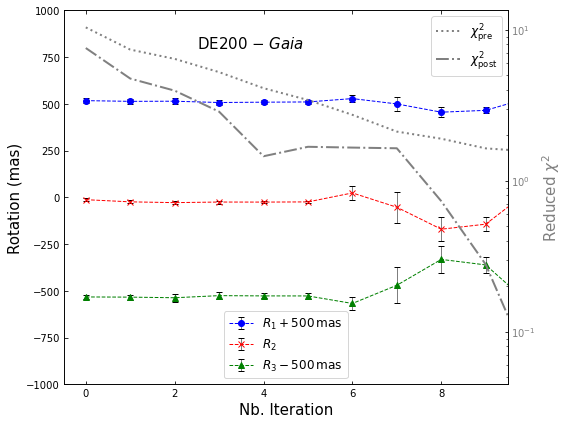

In [81]:
rot_vs_iter(
    pmt200_a,
    sig200_a,
    [-0.5, 9.5, -1000, 1000],
    fig_name="gedr3_orient-de200.eps",
    elw=0.5,
    add_text=[0.3, 0.9, "DE200 $-$ $Gaia$"],
    apr_chi2=apr_chi2_200_a,
    pst_chi2=pst_chi2_200_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=500
)

In [82]:
rot200_a, iqr200_a = find_pmt_est(pmt200_a)

dra_200, ddec_200 = calc_dpos(edr3_timing200, rot200_a)

a_chi2_200, p_chi2_200 = calc_chi2_4_fit(edr3_timing200, dra_200, ddec_200)

In [83]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200[0], iqr200[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200[1], iqr200[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200[2], iqr200[2]))

print("After removing J0857-4424, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[0], iqr200_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[1], iqr200_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[2], iqr200_a[2]))

Using all samples, the rotation parameters are
R1:      12 +/-     11 mas
R2:     -25 +/-     24 mas
R3:     -30 +/-     24 mas
After removing J0857-4424, the rotation parameters are
R1:      10 +/-      9 mas
R2:     -25 +/-     28 mas
R3:     -27 +/-     28 mas


## 3.3 DE405 vs Gaia 

In [84]:
pmt405, sig405, indx, apr_chi2_405, pst_chi2_405 = rot_fit_4_table(
    edr3_timing405)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 10     56.1     48.9      29.97       9.75      -6.63 J2032+4127    54938    297.7
 2  9     44.9     36.4      31.01       9.30      -7.31 J1024-0719    53000    121.6
 3  9     32.1     30.2      17.40      -0.08      -4.16 J1024-0719    53000    202.6
 4  8     15.6     10.9      -7.36     -16.53       6.66 J2027+4557    54250     94.6
 5  7      8.7      3.5      -7.82     -14.86      10.78 J1227-4853    56708     11.0
 6  6      2.6      1.9      -1.19      -6.66       5.10 J1723-2837    55667     11.6
 7  5      0.9      0.5       0.92      -5.41       0.62 J1012+5307    50700      0.5
 8  4      0.6      0.4       6.15      -1.28       0.42 J1958+2846    54800      1.2
 9  3      0.7      0.1       6.13      -1.27       0.50 J0437-4715    53019      0.0


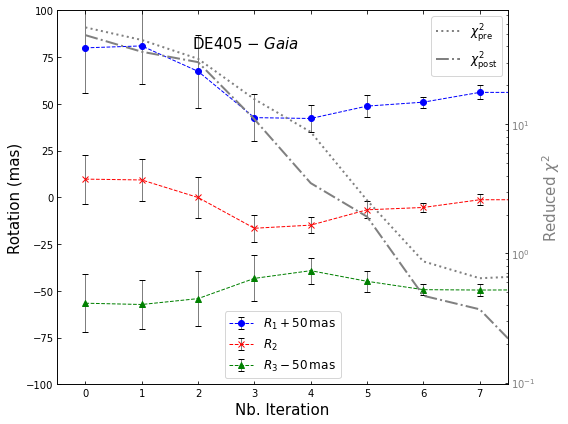

In [85]:
rot_vs_iter(
    pmt405,
    sig405,
    [-0.5, 7.5, -100, 100],
    #     "gedr3_orient-de405.eps",
    add_text=[0.3, 0.9, "DE405 $-$ $Gaia$"],
    apr_chi2=apr_chi2_405,
    pst_chi2=pst_chi2_405,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

In [86]:
rot405, iqr405 = find_pmt_est(pmt405)

dra_405, ddec_405 = calc_dpos(edr3_timing405, rot405)

a_chi2_405, p_chi2_405 = calc_chi2_4_fit(edr3_timing405, dra_405, ddec_405)

Let me try to remove some PSRs.

In [87]:
mask = (edr3_timing405["psr_name"] != "J0534+2200")
edr3_timing405_a = edr3_timing405[mask]

mask = (edr3_timing405["psr_name"] != "J2032+4127")
edr3_timing405_b = edr3_timing405[mask]

mask = (edr3_timing405["psr_name"] != "J0437-4715")
edr3_timing405_c = edr3_timing405[mask]

# mask = (
#     (edr3_timing405["psr_name"] != "J0534+2200")
#     & (edr3_timing405["psr_name"] != "J2032+4127")
#     & (edr3_timing405["psr_name"] != "J0437-4715")
# )

# mask = (
#     (edr3_timing405["psr_name"] != "J0534+2200")
#     & (edr3_timing405["psr_name"] != "J2032+4127")
# )

mask = (
    (np.fabs(edr3_timing405["dra"]) < 1000)
    & (np.fabs(edr3_timing405["ddec"]) < 1000)
)


edr3_timing405_d = edr3_timing405[mask]

In [88]:
nb_psr_405 = len(edr3_timing405_d.group_by("psr_name").groups)
nb_obs_405 = len(edr3_timing405_d)

print("After removing outliers, we have", nb_psr_405,
      "pulsars in the sample from DE405 vs. Gaia DR3 comparison with",
      nb_obs_405, "observations.")

After removing outliers, we have 9 pulsars in the sample from DE405 vs. Gaia DR3 comparison with 10 observations.


In [89]:
pmt405_a, sig405_a, indx, apr_chi2_405_a, pst_chi2_405_a = rot_fit_4_table(
    edr3_timing405_a)

print("")
pmt405_b, sig405_b, indx, apr_chi2_405_b, pst_chi2_405_b = rot_fit_4_table(
    edr3_timing405_b)

print("")
pmt405_c, sig405_c, indx, apr_chi2_405_c, pst_chi2_405_c = rot_fit_4_table(
    edr3_timing405_c)

print("")
pmt405_d, sig405_d, indx, apr_chi2_405_d, pst_chi2_405_d = rot_fit_4_table(
    edr3_timing405_d)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 10     56.1     48.9      29.97       9.75      -6.63 J2032+4127    54938    297.7
 2  9     44.9     36.4      31.01       9.30      -7.31 J1024-0719    53000    121.6
 3  9     32.1     30.2      17.40      -0.08      -4.16 J1024-0719    53000    202.6
 4  8     15.6     10.9      -7.36     -16.53       6.66 J2027+4557    54250     94.6
 5  7      8.7      3.5      -7.82     -14.86      10.78 J1227-4853    56708     11.0
 6  6      2.6      1.9      -1.19      -6.66       5.10 J1723-2837    55667     11.6
 7  5      0.9      0.5       0.92      -5.41       0.62 J1012+5307    50700      0.5
 8  4      0.6      0.4       6.15      -1.28       0.42 J1958+2846    54800      1.2
 9  3      0.7      0.1       6.13      -1.27       0.50 J0437-4715    53019      0.0

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  9     44.9     36.4      31.01       9.30      -7

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


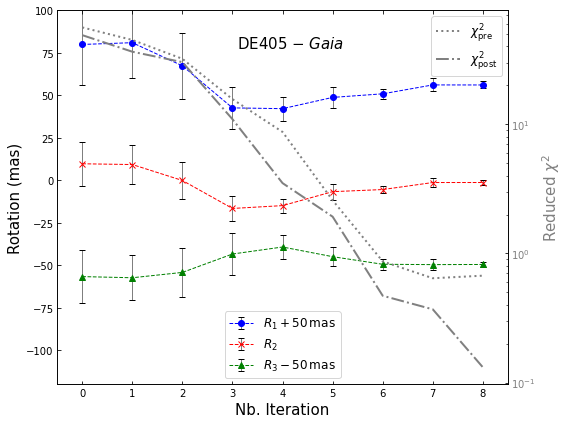

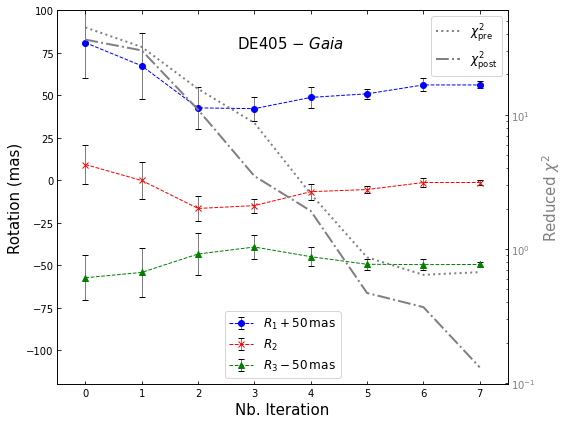

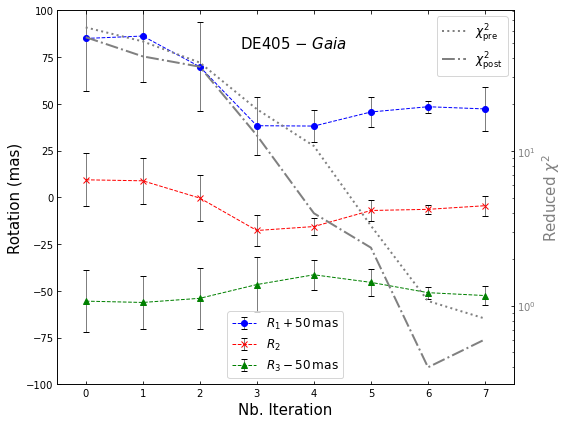

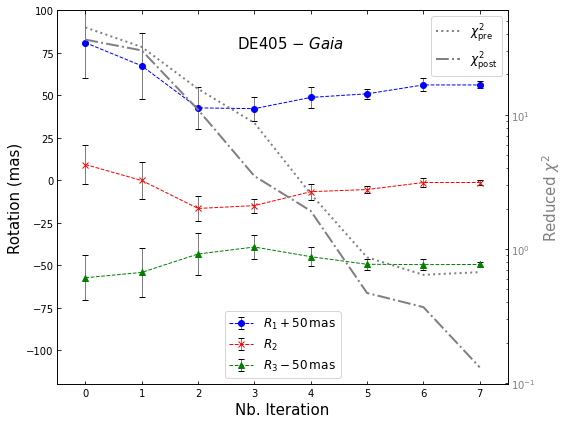

In [90]:
rot_vs_iter(
    pmt405_a,
    sig405_a,
    [-0.5, 8.5, -120, 100],
    add_text=[0.4, 0.9, "DE405 $-$ $Gaia$"],
    apr_chi2=apr_chi2_405_a,
    pst_chi2=pst_chi2_405_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

rot_vs_iter(
    pmt405_b,
    sig405_b,
    [-0.5, 7.5, -120, 100],
    add_text=[0.4, 0.9, "DE405 $-$ $Gaia$"],
    apr_chi2=apr_chi2_405_b,
    pst_chi2=pst_chi2_405_b,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

rot_vs_iter(
    pmt405_c,
    sig405_c,
    [-0.5, 7.5, -100, 100],
    add_text=[0.4, 0.9, "DE405 $-$ $Gaia$"],
    apr_chi2=apr_chi2_405_c,
    pst_chi2=pst_chi2_405_c,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

rot_vs_iter(
    pmt405_d,
    sig405_d,
    [-0.5, 7.5, -120, 100],
    fig_name="gedr3_orient-de405.eps",
    add_text=[0.4, 0.9, "DE405 $-$ $Gaia$"],
    apr_chi2=apr_chi2_405_d,
    pst_chi2=pst_chi2_405_d,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

In [91]:
rot405_a, iqr405_a = find_pmt_est(pmt405_a)
rot405_b, iqr405_b = find_pmt_est(pmt405_b)
rot405_c, iqr405_c = find_pmt_est(pmt405_c)
rot405_d, iqr405_d = find_pmt_est(pmt405_d)

# dra_405_a, ddec_405_a = calc_dpos(edr3_timing405_a, rot405_a)

# a_chi2_405_a, p_chi2_405_a = calc_chi2_4_fit(edr3_timing405_a, dra_405_a, ddec_405_a)

In [92]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot405[0], iqr405[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot405[1], iqr405[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot405[2], iqr405[2]))

print("After removing J0534+2200, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot405_a[0], iqr405_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot405_a[1], iqr405_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot405_a[2], iqr405_a[2]))

print("After removing J2032+4127, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot405_b[0], iqr405_b[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot405_b[1], iqr405_b[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot405_b[2], iqr405_b[2]))

print("After removing J0437-4715, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot405_c[0], iqr405_c[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot405_c[1], iqr405_c[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot405_c[2], iqr405_c[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot405_d[0], iqr405_d[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot405_d[1], iqr405_d[1]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot405_d[2], iqr405_d[2]))

Using all samples, the rotation parameters are
R1:       6 +/-     14 mas
R2:      -1 +/-      7 mas
R3:       1 +/-      7 mas
After removing J0534+2200, the rotation parameters are
R1:       6 +/-     14 mas
R2:      -1 +/-      7 mas
R3:       1 +/-      7 mas
After removing J2032+4127, the rotation parameters are
R1:       4 +/-      9 mas
R2:      -3 +/-      5 mas
R3:       1 +/-      5 mas
After removing J0437-4715, the rotation parameters are
R1:      -2 +/-     22 mas
R2:      -5 +/-      6 mas
R3:      -2 +/-      6 mas
After removing outliers, the rotation parameters are
R1:       4 +/-      9 mas
R2:      -3 +/-      6 mas
R3:       1 +/-      5 mas


## 3.4 DE421 vs Gaia

In [93]:
pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(
    edr3_timing421)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 11   1263.2    995.4      -2.42      17.62      37.35 J1928+1245    57974  21020.5
 2 10    155.3    110.5       8.91      17.55      -9.56 J1024-0719    55800    997.3
 3 10     93.6     77.2       6.43      10.59      -6.03 J1024-0719    55000    618.0
 4 10     64.5     57.4       4.96       6.55      -3.69 J1024-0719    55000    722.8
 5 10     30.7     29.3       3.18       1.79      -0.66 J1024-0719    54500    591.2
 6  9      4.2      3.3       1.73      -2.01       1.98 J1302-6350    55000     27.8
 7  8      3.1      2.2       1.23      -1.94       2.23 J1048+2339    56700     13.6
 8  7      1.9      1.6       1.28      -0.80       1.35 J1816+4510    56047      2.5
 9  6      1.7      1.0       2.27      -3.30      -2.30 J1431-4715    55756      1.5
10  5      1.5      0.9       0.56      -2.98       0.12 J1957+2516    56408      5.3
11  4      1.4      0.6       0.45      -3.44      -0.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


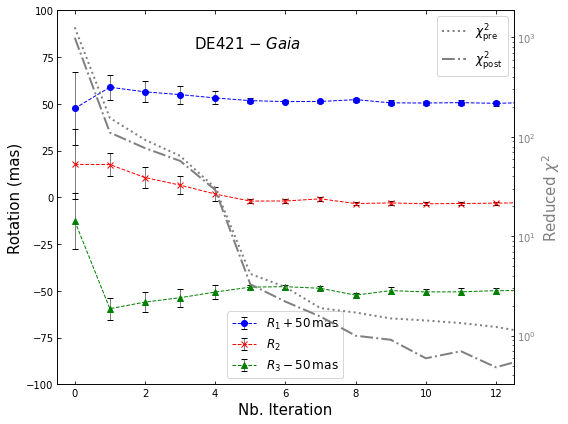

In [94]:
rot_vs_iter(
    pmt421,
    sig421,
    [-0.5, 12.5, -100, 100],
    "gedr3_orient-de421.eps",
    xaxis_range=np.arange(0, 13, 2),
    add_text=[0.3, 0.9, "DE421 $-$ $Gaia$"],
    apr_chi2=apr_chi2_421,
    pst_chi2=pst_chi2_421,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

In [95]:
rot421, iqr421 = find_pmt_est(pmt421)

dra_421, ddec_421 = calc_dpos(edr3_timing421, rot421)

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(edr3_timing421, dra_421, ddec_421)

## 3.5 DE430 vs Gaia

In [96]:
pmt430, sig430, indx, apr_chi2_430, pst_chi2_430 = rot_fit_4_table(
    edr3_timing430)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  4     11.5      9.5      29.38      79.38     -93.06 J1305-6455    57600     37.9
 2  4     11.3      2.5      63.93     170.87    -198.86 J1305-6455    57600      5.3
 3  3     11.1      2.2      54.36     145.56    -169.59 J1817-3618    57600      2.8


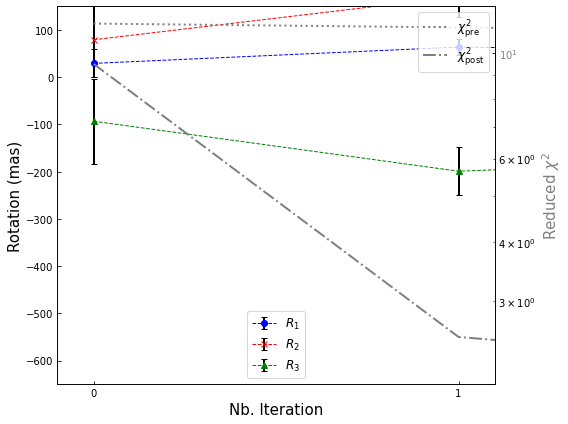

In [97]:
rot_vs_iter(
    pmt430,
    sig430,
    [-0.1, 1.1, -650, 150],
    apr_chi2=apr_chi2_430,
    pst_chi2=pst_chi2_430,
    xaxis_range=np.arange(0, 2, 1),
    ax_loc="lower center",
    ax1_loc="upper right",
)

In [98]:
# rot430, iqr430 = find_pmt_est(pmt430)

# dra_430, ddec_430 = calc_dpos(edr3_timing430, rot430)

# a_chi2_430, p_chi2_430 = calc_chi2_4_fit(edr3_timing430, dra_430, ddec_430)

rot430, iqr430, dra_430, ddec_430, a_chi2_430, p_chi2_430 = simple_rot_fit_4_table(
    edr3_timing430, ref="g"
)

[msg] There are 5 timing solutions for 4 pulsars
[msg] Before removing outliers, the reduced chi-squared is 7.70.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  5  4      7.7      9.5      29.38      79.38     -93.06      29.50      78.05      90.25


## 3.6 DE436 vs Gaia

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  3    830.3    314.1      26.63      35.05     -15.88 J1024-0719    56239    523.9
 2  3    467.9    281.0      20.24      21.00     -14.69 J1024-0719    55636    677.8
 3  3    238.0    191.8      14.01       6.21     -14.11 J1024-0719    55000    608.4


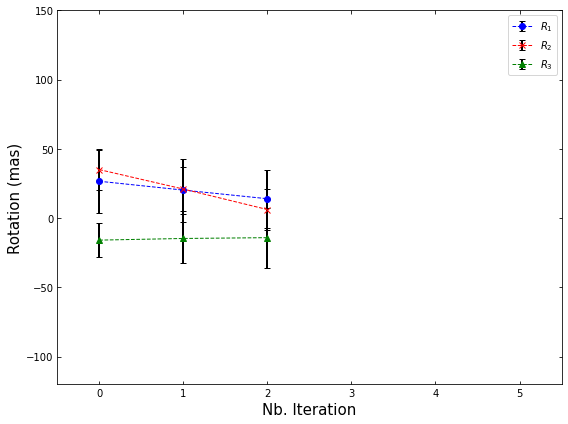

In [99]:
pmt436, sig436, indx, apr_chi2_436, pst_chi2_436 = rot_fit_4_table(
    edr3_timing436)
rot_vs_iter(pmt436, sig436, [-0.5, 5.5, -120, 150])

In [100]:
# rot436, iqr436 = find_pmt_est(pmt436)

# dra_436, ddec_436 = calc_dpos(edr3_timing436, rot436)

# a_chi2_436, p_chi2_436 = calc_chi2_4_fit(edr3_timing436, dra_436, ddec_436)

rot436, iqr436, dra_436, ddec_436, a_chi2_436, p_chi2_436 = simple_rot_fit_4_table(
    edr3_timing436, ref="g"
)

[msg] There are 6 timing solutions for 3 pulsars
[msg] Before removing outliers, the reduced chi-squared is 603.89.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  6  3    603.9    314.1      26.63      35.05     -15.88      22.65      14.73      12.50


# 4 Summarize the results

The comparison of formal uncertainties of pulsar positions.

In [101]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t",
             "RA_err_g", "dec_err_g", "pos_err_t"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and Gaia positions (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"],
)

print(tbl)

Positional formal uncertainty for timing and Gaia positions (mas)
      RA_err_t dec_err_t pos_err_t RA_err_g dec_err_g pos_err_t
---------------------------------------------------------------
DE200    56.97    140.00    151.15     0.25      0.26      0.36
DE405     6.16     14.39     16.30     0.18      0.21      0.28
DE421     0.32      0.70      0.77     0.25      0.26      0.36
DE430    58.33    200.00    207.13     0.03      0.03      0.04
DE436     0.05      0.10      0.11     0.25      0.26      0.36
---------------------------------------------------------------


A short table to summarize the orientation between DE frame and Gaia frame.

In [102]:
mydata = [
    [
        nb_psr_200,
        nb_obs_200,
        rot200_a[0],
        iqr200_a[0],
        rot200_a[1],
        iqr200_a[1],
        rot200_a[2],
        iqr200_a[2],
        a_chi2_200,
        p_chi2_200,
    ],
    [
        nb_psr_405,
        nb_obs_405,
        rot405_d[0],
        iqr405_d[0],
        rot405_d[1],
        iqr405_d[1],
        rot405_d[2],
        iqr405_d[2],
        a_chi2_405,
        p_chi2_405,
    ],
    [
        nb_psr_421,
        nb_obs_421,
        rot421[0],
        iqr421[0],
        rot421[1],
        iqr421[1],
        rot421[2],
        iqr421[2],
        a_chi2_421,
        p_chi2_421,
    ],
    [
        nb_psr_430,
        nb_obs_430,
        rot430[0],
        iqr430[0],
        rot430[1],
        iqr430[1],
        rot430[2],
        iqr430[2],
        a_chi2_430,
        p_chi2_430,
    ],
    [
        nb_psr_436,
        nb_obs_436,
        rot436[0],
        iqr436[0],
        rot436[1],
        iqr436[1],
        rot436[2],
        iqr436[2],
        a_chi2_436,
        p_chi2_436,
    ],
]

myheaders = [
    "Nb.PSR",
    "Nb.Obs",
    "R1",
    "R1_err",
    "R2",
    "R2_err",
    "R3",
    "R3_err",
    "ApreFitChi2",
    "PostFitChi2",
]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. Gaia frame (mas)",
    data_fmts=[
        "%d",
        "%d",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.2f",
        "%6.2f",
    ],
)

print(tbl)

                    Orientation of DE frame wrt. Gaia frame (mas)                    
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200     11     13   10.3    9.1  -25.1   16.5  -27.4   27.6     8081.43     8003.68
DE405      9     10    3.5    8.7   -3.3    5.7    0.6    4.6       48.11       47.10
DE421     11     18    1.3    1.8   -2.0    6.3   -0.2    2.2     1154.97     1167.60
DE430      4      5   29.4   29.5   79.4   78.1  -93.1   90.3        7.70        9.49
DE436      3      6   26.6   22.6   35.1   14.7  -15.9   12.5      603.89      314.06
-------------------------------------------------------------------------------------
